# Consumption Smoothing

## Overview


In this lecture, we'll study a famous model of the "consumption function" that Milton Friedman {cite}`Friedman1956` and Robert Hall {cite}`Hall1978`)  proposed to fit some empirical data patterns that the original  Keynesian consumption function  described in this QuantEcon lecture {doc}`geometric series <geom_series>`  missed.

In this lecture, we'll study what is often  called the "consumption-smoothing model"  using  matrix multiplication and matrix inversion, the same tools that we used in this QuantEcon lecture {doc}`present values <pv>`. 

Formulas presented in  {doc}`present value formulas<pv>` are at the core of the consumption smoothing model because we shall use them to define a consumer's "human wealth".

The  key idea that inspired Milton Friedman was that a person's non-financial income, i.e., his or
her wages from working, could be viewed as a dividend stream from that person's ''human capital''
and that standard asset-pricing formulas could be applied to compute a person's
''non-financial wealth'' that capitalizes the  earnings stream.  

```{note}
As we'll see in this QuantEcon lecture  {doc}`equalizing difference model <equalizing_difference>`,
Milton Friedman had used this idea  in his PhD thesis at Columbia University, 
eventually published as {cite}`kuznets1939incomes` and {cite}`friedman1954incomes`.
```

It will take a while for a "present value" or asset price explicilty to appear in this lecture, but when it does it will be a key actor.


## Analysis

As usual, we'll start with by importing some Python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

The model describes  a consumer who lives from time $t=0, 1, \ldots, T$, receives a stream $\{y_t\}_{t=0}^T$ of non-financial income and chooses a consumption stream $\{c_t\}_{t=0}^T$.

We usually think of the non-financial income stream as coming from the person's salary from supplying labor.  

The model  takes a non-financial income stream as an input, regarding it as "exogenous" in the sense of not being determined by the model. 

The consumer faces a gross interest rate of $R >1$ that is constant over time, at which she is free to borrow or lend, up to  limits that we'll describe below.

To set up the model, let 

 * $T \geq 2$  be a positive integer that constitutes a time-horizon. 
 * $y = \{y_t\}_{t=0}^T$ be an exogenous  sequence of non-negative non-financial incomes $y_t$. 
 * $a = \{a_t\}_{t=0}^{T+1}$ be a sequence of financial wealth.  
 * $c = \{c_t\}_{t=0}^T$ be a sequence of non-negative consumption rates. 
 * $R \geq 1$ be a fixed gross one period rate of return on financial assets. 
 * $\beta \in (0,1)$ be a fixed discount factor.  
 * $a_0$ be a given initial level of financial assets
 * $a_{T+1} \geq 0$  be a terminal condition on final assets. 

The sequence of financial wealth $a$ is to be determined by the model.

We require it to satisfy  two  **boundary conditions**:

   * it must  equal an exogenous value  $a_0$ at time $0$ 
   * it must equal or exceed an exogenous value  $a_{T+1}$ at time $T+1$.

The **terminal condition** $a_{T+1} \geq 0$ requires that the consumer not leave the model in debt.

(We'll soon see that a utility maximizing consumer won't want to die leaving positive assets, so she'll arrange her affairs to make
$a_{T+1} = 0$.)

The consumer faces a sequence of budget constraints that  constrains   sequences $(y, c, a)$

$$
a_{t+1} = R (a_t+ y_t - c_t), \quad t =0, 1, \ldots T
$$ (eq:a_t)

Equations {eq}`eq:a_t` constitute  $T+1$ such budget constraints, one for each $t=0, 1, \ldots, T$. 

Given a sequence $y$ of non-financial incomes, a large  set of pairs $(a, c)$ of (financial wealth, consumption) sequences  satisfy the sequence of budget constraints {eq}`eq:a_t`. 

Our model has the following logical flow.

 * start with an exogenous non-financial income sequence $y$, an initial financial wealth $a_0$, and 
 a candidate consumption path $c$.
 
 * use the system of equations {eq}`eq:a_t` for $t=0, \ldots, T$ to compute a path $a$ of financial wealth
 
 * verify that $a_{T+1}$ satisfies the terminal wealth constraint $a_{T+1} \geq 0$. 
    
     * If it does, declare that the candidate path is **budget feasible**. 
 
     * if the candidate consumption path is not budget feasible, propose a less greedy consumption  path and start over
     
Below, we'll describe how to execute these steps using linear algebra -- matrix inversion and multiplication.

The above procedure seems like a sensible way to find "budget-feasible" consumption paths $c$, i.e., paths that are consistent
with the exogenous non-financial income stream $y$, the initial financial  asset level $a_0$, and the terminal asset level $a_{T+1}$.

In general, there are **many** budget feasible consumption paths $c$.

Among all budget-feasible consumption paths, which one should a consumer want?


To answer this question, we shall eventually evaluate alternative budget feasible consumption paths $c$ using the following utility functional or **welfare criterion**:

```{math}
:label: welfare

W = \sum_{t=0}^T \beta^t (g_1 c_t - \frac{g_2}{2} c_t^2 )
```

where $g_1 > 0, g_2 > 0$.  

When $\beta R \approx 1$, the fact that the utility function $g_1 c_t - \frac{g_2}{2} c_t^2$ has diminishing marginal utility imparts a preference for consumption that is very smooth.  

Indeed, we shall see that when $\beta R = 1$ (a condition assumed by Milton Friedman {cite}`Friedman1956` and Robert Hall {cite}`Hall1978`),  criterion {eq}`welfare` assigns higher welfare to smoother consumption paths.

By **smoother** we mean as close as possible to being constant over time.  

The preference for smooth consumption paths that is built into the model gives it the  name "consumption smoothing model".

Let's dive in and do some calculations that will help us understand how the model works. 

Here we use default parameters $R = 1.05$, $g_1 = 1$, $g_2 = 1/2$, and $T = 65$. 

We create a Python **namedtuple** to store these parameters with default values.

In [2]:
ConsumptionSmoothing = namedtuple("ConsumptionSmoothing", 
                        ["R", "g1", "g2", "β_seq", "T"])

def create_consumption_smoothing_model(R=1.05, g1=1, g2=1/2, T=65):
    β = 1/R
    β_seq = np.array([β**i for i in range(T+1)])
    return ConsumptionSmoothing(R, g1, g2, 
                                β_seq, T)

## Friedman-Hall consumption-smoothing model

A key object is what Milton Friedman called "human" or "non-financial" wealth at time $0$:


$$
h_0 \equiv \sum_{t=0}^T R^{-t} y_t = \begin{bmatrix} 1 & R^{-1} & \cdots & R^{-T} \end{bmatrix}
\begin{bmatrix} y_0 \cr y_1  \cr \vdots \cr y_T \end{bmatrix}
$$

Human or non-financial wealth  at time $0$ is evidently just the present value of the consumer's non-financial income stream $y$. 

Formally it very much resembles the asset price that we computed in this QuantEcon lecture {doc}`present values <pv>`.

Indeed, this is why Milton Friedman called it "human capital". 

By iterating on equation {eq}`eq:a_t` and imposing the terminal condition 

$$
a_{T+1} = 0,
$$

it is possible to convert a sequence of budget constraints {eq}`eq:a_t` into a single intertemporal constraint

$$ 
\sum_{t=0}^T R^{-t} c_t = a_0 + h_0. 
$$ (eq:budget_intertemp)

Equation {eq}`eq:budget_intertemp`  says that the present value of the consumption stream equals the sum of finanical and non-financial (or human) wealth.

Robert Hall {cite}`Hall1978` showed that when $\beta R = 1$, a condition Milton Friedman had also  assumed, it is "optimal" for a consumer to smooth consumption by setting 

$$ 
c_t = c_0 \quad t =0, 1, \ldots, T
$$

(Later we'll present a "variational argument" that shows that this constant path maximizes
criterion {eq}`welfare` when $\beta R =1$.)

In this case, we can use the intertemporal budget constraint to write 

$$
c_t = c_0  = \left(\sum_{t=0}^T R^{-t}\right)^{-1} (a_0 + h_0), \quad t= 0, 1, \ldots, T.
$$ (eq:conssmoothing)

Equation {eq}`eq:conssmoothing` is the consumption-smoothing model in a nutshell.


## Mechanics of Consumption smoothing model  

As promised, we'll provide step-by-step instructions on how to use linear algebra, readily implemented in Python, to compute all  objects in play in  the consumption-smoothing model.

In the calculations below,  we'll  set default values of  $R > 1$, e.g., $R = 1.05$, and $\beta = R^{-1}$.

### Step 1

For a $(T+1) \times 1$  vector $y$, use matrix algebra to compute $h_0$

$$
h_0 = \sum_{t=0}^T R^{-t} y_t = \begin{bmatrix} 1 & R^{-1} & \cdots & R^{-T} \end{bmatrix}
\begin{bmatrix} y_0 \cr y_1  \cr \vdots \cr y_T \end{bmatrix}
$$

### Step 2

Compute an  time $0$   consumption $c_0 $ :

$$
c_t = c_0 = \left( \frac{1 - R^{-1}}{1 - R^{-(T+1)}} \right) (a_0 + \sum_{t=0}^T R^{-t} y_t ) , \quad t = 0, 1, \ldots, T
$$

### Step 3

Use  the system of equations {eq}`eq:a_t` for $t=0, \ldots, T$ to compute a path $a$ of financial wealth.

To do this, we translate that system of difference equations into a single matrix equation as follows:


$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 & 0 \cr
-R & 1 & 0 & \cdots & 0 & 0 & 0 \cr
0 & -R & 1 & \cdots & 0 & 0 & 0 \cr
\vdots  &\vdots & \vdots & \cdots & \vdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -R & 1 & 0 \cr
0 & 0 & 0 & \cdots & 0 & -R & 1
\end{bmatrix} 
\begin{bmatrix} a_1 \cr a_2 \cr a_3 \cr \vdots \cr a_T \cr a_{T+1} 
\end{bmatrix}
= R 
\begin{bmatrix} y_0 + a_0 - c_0 \cr y_1 - c_0 \cr y_2 - c_0 \cr \vdots\cr y_{T-1} - c_0 \cr y_T - c_0
\end{bmatrix}
$$

Multiply both sides by the inverse of the matrix on the left side to compute

$$
 \begin{bmatrix} a_1 \cr a_2 \cr a_3 \cr \vdots \cr a_T \cr a_{T+1} \end{bmatrix}
$$


Because we have built into  our calculations that the consumer leaves the model  with exactly zero assets, just barely satisfying the
terminal condition that $a_{T+1} \geq 0$, it should turn out   that 

$$
a_{T+1} = 0.
$$
 

Let's verify this with  Python code.

First we implement the model with `compute_optimal`

In [3]:
def compute_optimal(model, a0, y_seq):
    R, T = model.R, model.T

    # non-financial wealth
    h0 = model.β_seq @ y_seq     # since β = 1/R

    # c0
    c0 = (1 - 1/R) / (1 - (1/R)**(T+1)) * (a0 + h0)
    c_seq = c0*np.ones(T+1)

    # verify
    A = np.diag(-R*np.ones(T), k=-1) + np.eye(T+1)
    b = y_seq - c_seq
    b[0] = b[0] + a0

    a_seq = np.linalg.inv(A) @ b
    a_seq = np.concatenate([[a0], a_seq])

    return c_seq, a_seq, h0

We use an example where the consumer inherits $a_0<0$.

This  can be interpreted as a student debt.

The non-financial process $\{y_t\}_{t=0}^{T}$ is constant and positive up to $t=45$ and then becomes zero afterward.

The drop in non-financial income late in life reflects retirement from work.

In [4]:
# Financial wealth
a0 = -2     # such as "student debt"

# non-financial Income process
y_seq = np.concatenate([np.ones(46), np.zeros(20)])

cs_model = create_consumption_smoothing_model()
c_seq, a_seq, h0 = compute_optimal(cs_model, a0, y_seq)

print('check a_T+1=0:', 
      np.abs(a_seq[-1] - 0) <= 1e-8)

check a_T+1=0: True


The graphs below  show  paths of non-financial income, consumption, and financial assets.

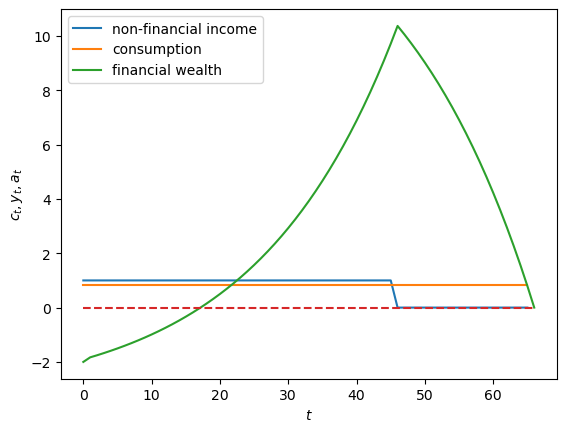

In [5]:
# Sequence Length
T = cs_model.T

plt.plot(range(T+1), y_seq, label='non-financial income')
plt.plot(range(T+1), c_seq, label='consumption')
plt.plot(range(T+2), a_seq, label='financial wealth')
plt.plot(range(T+2), np.zeros(T+2), '--')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$c_t,y_t,a_t$')
plt.show()

Note that $a_{T+1} = 0$, as anticipated.

We can  evaluate  welfare criterion {eq}`welfare`

In [6]:
def welfare(model, c_seq):
    β_seq, g1, g2 = model.β_seq, model.g1, model.g2

    u_seq = g1 * c_seq - g2/2 * c_seq**2
    return β_seq @ u_seq

print('Welfare:', welfare(cs_model, c_seq))

Welfare: 13.285050962183433


### Experiments

In this section we decribe  how a  consumption sequence would optimally respond to different  sequences sequences of non-financial income.

First we create  a function `plot_cs` that generate graphs for different instances of the  consumption smoothing model `cs_model`.

This will  help us avoid rewriting code to plot outcomes for different non-financial income sequences.

In [7]:
def plot_cs(model,    # consumption smoothing model      
            a0,       # initial financial wealth
            y_seq     # non-financial income process
           ):
    
    # Compute optimal consumption
    c_seq, a_seq, h0 = compute_optimal(model, a0, y_seq)
    
    # Sequence length
    T = cs_model.T
    
    # Generate plot
    plt.plot(range(T+1), y_seq, label='non-financial income')
    plt.plot(range(T+1), c_seq, label='consumption')
    plt.plot(range(T+2), a_seq, label='financial wealth')
    plt.plot(range(T+2), np.zeros(T+2), '--')
    
    plt.legend()
    plt.xlabel(r'$t$')
    plt.ylabel(r'$c_t,y_t,a_t$')
    plt.show()

In the experiments below, please study how consumption and financial asset sequences vary accross different sequences for non-financial income.

#### Experiment 1: one-time gain/loss

We first assume a one-time windfall of $W_0$ in year 21 of the income sequence $y$.  

We'll make $W_0$ big - positive to indicate a one-time windfall, and negative to indicate a one-time "disaster".

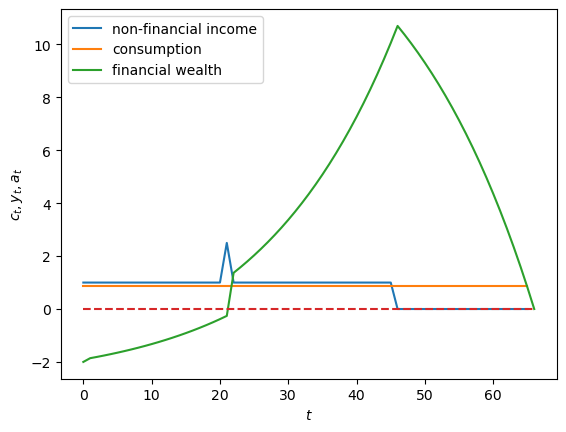

In [8]:
# Windfall W_0 = 2.5
y_seq_pos = np.concatenate([np.ones(21), np.array([2.5]), np.ones(24), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_pos)

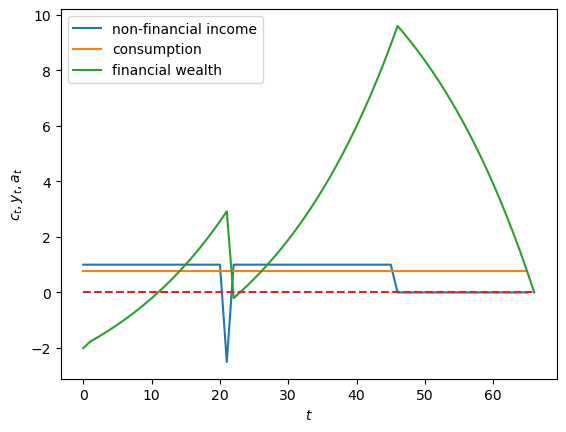

In [9]:
# Disaster W_0 = -2.5
y_seq_neg = np.concatenate([np.ones(21), np.array([-2.5]), np.ones(24), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_neg)

#### Experiment 2: permanent wage gain/loss

Now we assume a permanent  increase in income of $W$ in year 21 of the $y$-sequence.

Again we can study positive and negative cases

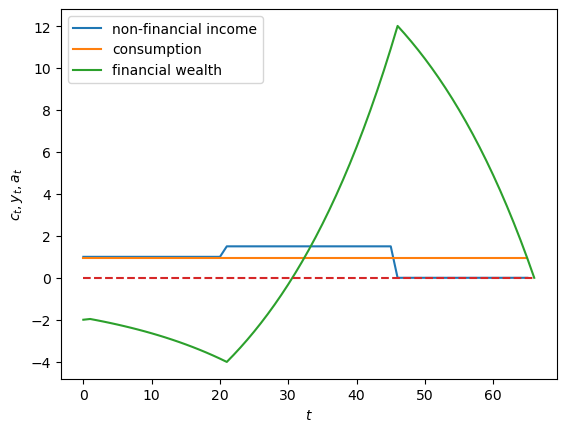

In [10]:
# Positive permanent income change W = 0.5 when t >= 21
y_seq_pos = np.concatenate(
    [np.ones(21), 1.5*np.ones(25), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_pos)

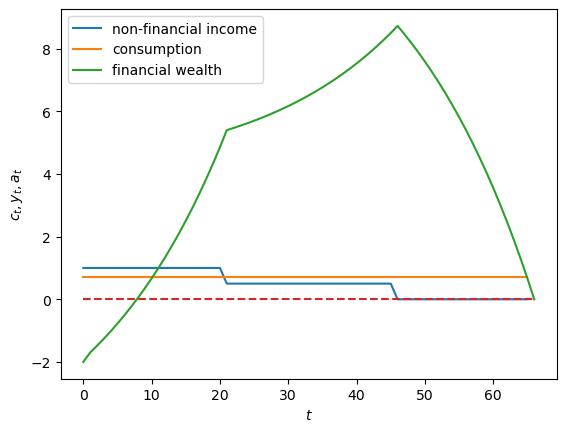

In [11]:
# Negative permanent income change W = -0.5 when t >= 21
y_seq_neg = np.concatenate(
    [np.ones(21), .5*np.ones(25), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_neg)

#### Experiment 3: a late starter

Now we simulate a $y$ sequence in which a person gets zero for 46 years, and then works and gets 1 for the last 20 years of life (a "late starter")

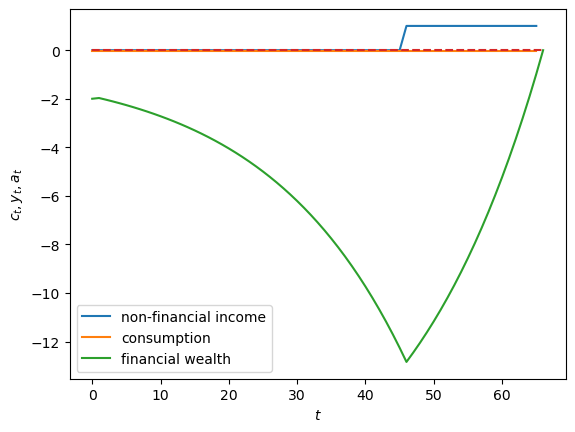

In [12]:
# Late starter
y_seq_late = np.concatenate(
    [np.zeros(46), np.ones(20)])

plot_cs(cs_model, a0, y_seq_late)

#### Experiment 4: geometric earner

Now we simulate a geometric $y$ sequence in which a person gets $y_t = \lambda^t y_0$ in first 46 years.

We first experiment with $\lambda = 1.05$

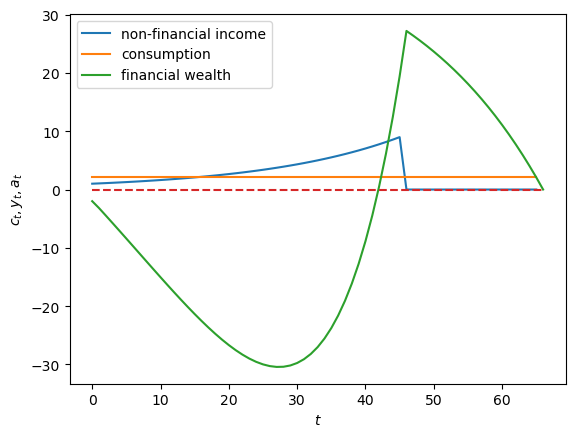

In [13]:
# Geometric earner parameters where λ = 1.05
λ = 1.05
y_0 = 1
t_max = 46

# Generate geometric y sequence
geo_seq = λ ** np.arange(t_max) * y_0 
y_seq_geo = np.concatenate(
            [geo_seq, np.zeros(20)])

plot_cs(cs_model, a0, y_seq_geo)

Now we show the behavior when $\lambda = 0.95$

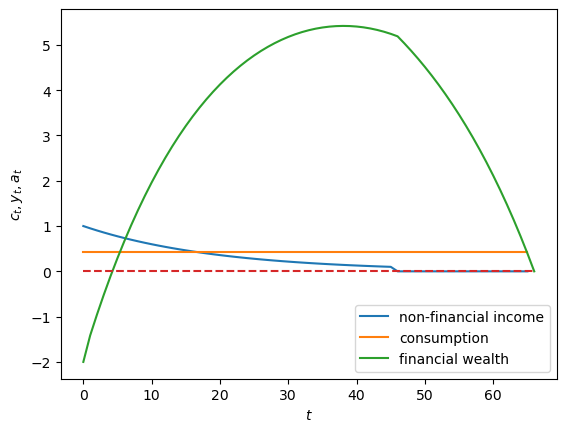

In [14]:
λ = 0.95

geo_seq = λ ** np.arange(t_max) * y_0 
y_seq_geo = np.concatenate(
            [geo_seq, np.zeros(20)])

plot_cs(cs_model, a0, y_seq_geo)

What happens when $\lambda$ is negative

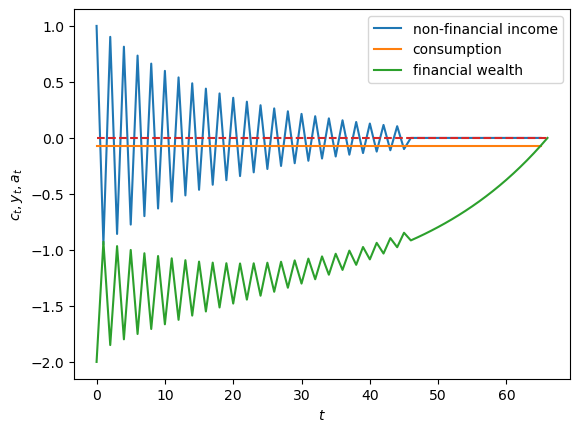

In [15]:
λ = -0.95

geo_seq = λ ** np.arange(t_max) * y_0 
y_seq_geo = np.concatenate(
            [geo_seq, np.zeros(20)])

plot_cs(cs_model, a0, y_seq_geo)

### Feasible consumption variations

We promised to justify  our claim that a constant consumption play $c_t = c_0$ for all
$t$ is optimal.  

Let's do that now.

The approach we'll take is  an elementary  example  of the "calculus of variations". 

Let's dive in and see what the key idea is.  

To explore what types of consumption paths are welfare-improving, we shall create an **admissible consumption path variation sequence** $\{v_t\}_{t=0}^T$
that satisfies

$$
\sum_{t=0}^T R^{-t} v_t = 0
$$

This equation says that the **present value** of admissible consumption path variations must be zero.

So once again, we encounter a formula for the present value of an "asset":

   * we require that the present value of consumption path variations be zero.

Here we'll restrict ourselves to  a two-parameter class of admissible consumption path variations
of the form

$$
v_t = \xi_1 \phi^t - \xi_0
$$

We say two and not three-parameter class because $\xi_0$ will be a function of $(\phi, \xi_1; R)$ that guarantees that the variation sequence is feasible. 

Let's compute that function.

We require

$$
\sum_{t=0}^T R^{-t}\left[ \xi_1 \phi^t - \xi_0 \right] = 0
$$

which implies that

$$
\xi_1 \sum_{t=0}^T \phi_t R^{-t} - \xi_0 \sum_{t=0}^T R^{-t} = 0
$$

which implies that

$$
\xi_1 \frac{1 - (\phi R^{-1})^{T+1}}{1 - \phi R^{-1}} - \xi_0 \frac{1 - R^{-(T+1)}}{1-R^{-1} } =0
$$

which implies that

$$
\xi_0 = \xi_0(\phi, \xi_1; R) = \xi_1 \left(\frac{1 - R^{-1}}{1 - R^{-(T+1)}}\right) \left(\frac{1 - (\phi R^{-1})^{T+1}}{1 - \phi R^{-1}}\right)
$$ 

This is our formula for $\xi_0$.  

**Key Idea:** if $c^o$ is a budget-feasible consumption path, then so is $c^o + v$,
where $v$ is a budget-feasible variation.

Given $R$, we thus have a two parameter class of budget feasible variations $v$ that we can use
to compute alternative consumption paths, then evaluate their welfare.

Now let's compute and plot consumption path variations

In [16]:
def compute_variation(model, ξ1, ϕ, a0, y_seq, verbose=1):
    R, T, β_seq = model.R, model.T, model.β_seq

    ξ0 = ξ1*((1 - 1/R) / (1 - (1/R)**(T+1))) * ((1 - (ϕ/R)**(T+1)) / (1 - ϕ/R))
    v_seq = np.array([(ξ1*ϕ**t - ξ0) for t in range(T+1)])
    
    if verbose == 1:
        print('check feasible:', np.isclose(β_seq @ v_seq, 0))     # since β = 1/R

    c_opt, _, _ = compute_optimal(model, a0, y_seq)
    cvar_seq = c_opt + v_seq

    return cvar_seq

We visualize variations for $\xi_1 \in \{.01, .05\}$ and $\phi \in \{.95, 1.02\}$

variation 0: ξ1=0.01, ϕ=0.95
check feasible: True
welfare=13.285009346064836
----------------------------------------------------------------
variation 1: ξ1=0.01, ϕ=1.02
check feasible: True
welfare=13.284911631015438
----------------------------------------------------------------
variation 2: ξ1=0.05, ϕ=0.95
check feasible: True
welfare=13.284010559218512
----------------------------------------------------------------
variation 3: ξ1=0.05, ϕ=1.02
check feasible: True
welfare=13.28156768298361
----------------------------------------------------------------


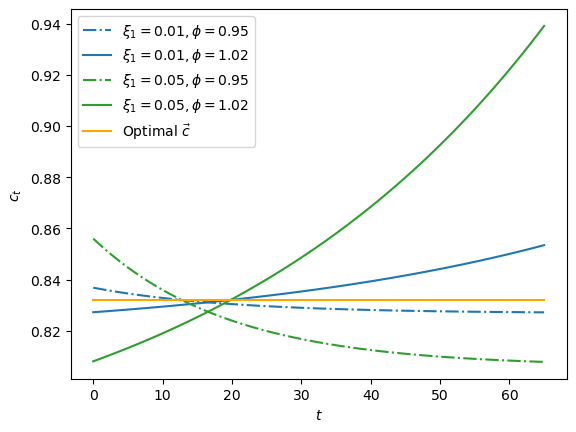

In [17]:
fig, ax = plt.subplots()

ξ1s = [.01, .05]
ϕs= [.95, 1.02]
colors = {.01: 'tab:blue', .05: 'tab:green'}

params = np.array(np.meshgrid(ξ1s, ϕs)).T.reshape(-1, 2)

for i, param in enumerate(params):
    ξ1, ϕ = param
    print(f'variation {i}: ξ1={ξ1}, ϕ={ϕ}')
    cvar_seq = compute_variation(model=cs_model, 
                                 ξ1=ξ1, ϕ=ϕ, a0=a0, 
                                 y_seq=y_seq)
    print(f'welfare={welfare(cs_model, cvar_seq)}')
    print('-'*64)
    if i % 2 == 0:
        ls = '-.'
    else: 
        ls = '-'  
    ax.plot(range(T+1), cvar_seq, ls=ls, 
            color=colors[ξ1], 
            label=fr'$\xi_1 = {ξ1}, \phi = {ϕ}$')

plt.plot(range(T+1), c_seq, 
         color='orange', label=r'Optimal $\vec{c}$ ')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$c_t$')
plt.show()

We can even use the Python `np.gradient` command to compute derivatives of welfare with respect to our two parameters.  

We are teaching the key idea beneath the **calculus of variations**.

First, we define the welfare with respect to $\xi_1$ and $\phi$

In [18]:
def welfare_rel(ξ1, ϕ):
    """
    Compute welfare of variation sequence 
    for given ϕ, ξ1 with a consumption smoothing model
    """
    
    cvar_seq = compute_variation(cs_model, ξ1=ξ1, 
                                 ϕ=ϕ, a0=a0, 
                                 y_seq=y_seq, 
                                 verbose=0)
    return welfare(cs_model, cvar_seq)

# Vectorize the function to allow array input
welfare_vec = np.vectorize(welfare_rel)

Then we can visualize the relationship between welfare and $\xi_1$ and compute its derivatives

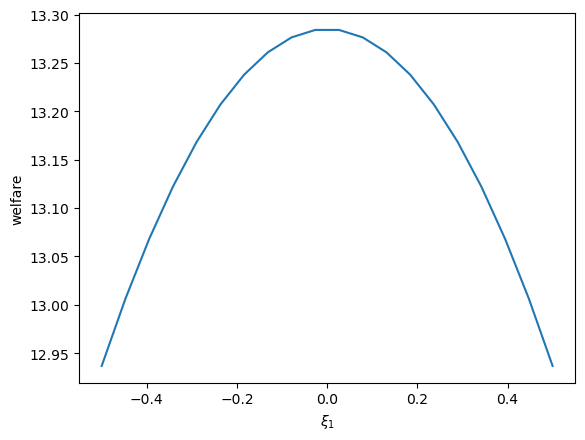

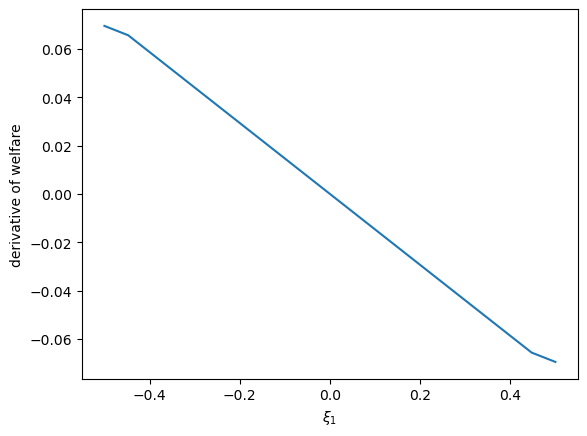

In [19]:
ξ1_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, welfare_vec(ξ1_arr, 1.02))
plt.ylabel('welfare')
plt.xlabel(r'$\xi_1$')
plt.show()

welfare_grad = welfare_vec(ξ1_arr, 1.02)
welfare_grad = np.gradient(welfare_grad)
plt.plot(ξ1_arr, welfare_grad)
plt.ylabel('derivative of welfare')
plt.xlabel(r'$\xi_1$')
plt.show()

The same can be done on $\phi$

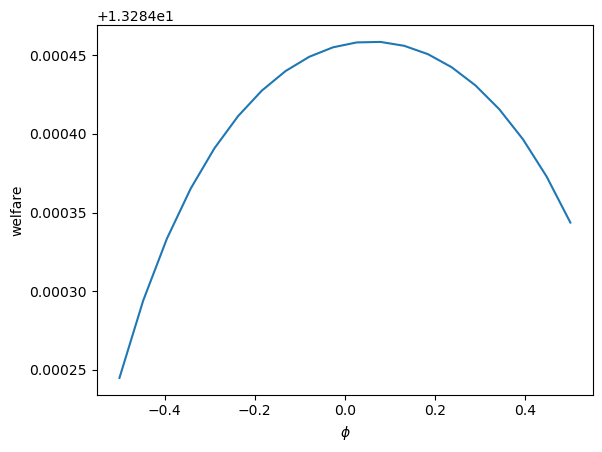

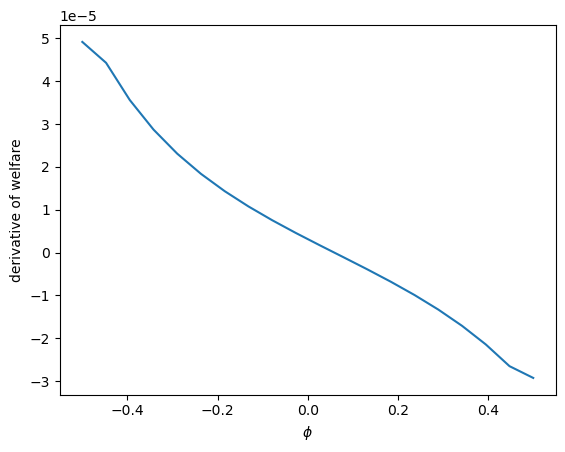

In [20]:
ϕ_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, welfare_vec(0.05, ϕ_arr))
plt.ylabel('welfare')
plt.xlabel(r'$\phi$')
plt.show()

welfare_grad = welfare_vec(0.05, ϕ_arr)
welfare_grad = np.gradient(welfare_grad)
plt.plot(ξ1_arr, welfare_grad)
plt.ylabel('derivative of welfare')
plt.xlabel(r'$\phi$')
plt.show()

## Wrapping up the consumption-smoothing model

The consumption-smoothing model of Milton Friedman {cite}`Friedman1956` and Robert Hall {cite}`Hall1978`) is a cornerstone of modern macro that has important ramifications for the size of the Keynesian  "fiscal policy multiplier" described briefly in
QuantEcon lecture {doc}`geometric series <geom_series>`.  

In particular,  it  **lowers** the government expenditure  multiplier relative to  one implied by
the original Keynesian consumption function presented in {doc}`geometric series <geom_series>`.

Friedman's   work opened the door to an enlighening literature on the aggregate consumption function and associated government expenditure  multipliers that
remains  active today.  


## Appendix: solving difference equations with linear algebra

In the preceding sections we have used linear algebra to solve a consumption smoothing model.  

The same tools from linear algebra -- matrix multiplication and matrix inversion -- can be used  to study many other dynamic models.

We'll conclude this lecture by giving a couple of examples.

We'll describe a useful way of representing and "solving" linear difference equations. 

To generate some $y$ vectors, we'll just write down a linear difference equation
with appropriate initial conditions and then   use linear algebra to solve it.

### First-order difference equation

We'll start with a first-order linear difference equation for $\{y_t\}_{t=0}^T$:

$$
y_{t} = \lambda y_{t-1}, \quad t = 1, 2, \ldots, T
$$

where  $y_0$ is a given  initial condition.


We can cast this set of $T$ equations as a single  matrix equation

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 \cr
-\lambda & 1 & 0 & \cdots & 0 & 0 \cr
0 & -\lambda & 1 & \cdots & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -\lambda & 1 
\end{bmatrix} 
\begin{bmatrix}
y_1 \cr y_2 \cr y_3 \cr \vdots \cr y_T 
\end{bmatrix}
= 
\begin{bmatrix} 
\lambda y_0 \cr 0 \cr 0 \cr \vdots \cr 0 
\end{bmatrix}
$$ (eq:first_order_lin_diff)


Multiplying both sides of {eq}`eq:first_order_lin_diff`  by the  inverse of the matrix on the left provides the solution

```{math}
:label: fst_ord_inverse

\begin{bmatrix} 
y_1 \cr y_2 \cr y_3 \cr \vdots \cr y_T 
\end{bmatrix} 
= 
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 \cr
\lambda & 1 & 0 & \cdots & 0 & 0 \cr
\lambda^2 & \lambda & 1 & \cdots & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
\lambda^{T-1} & \lambda^{T-2} & \lambda^{T-3} & \cdots & \lambda & 1 
\end{bmatrix}
\begin{bmatrix} 
\lambda y_0 \cr 0 \cr 0 \cr \vdots \cr 0 
\end{bmatrix}
```

```{exercise}
:label: consmooth_ex1

To get {eq}`fst_ord_inverse`, we multiplied both sides of  {eq}`eq:first_order_lin_diff` by  the inverse of the matrix $A$. Please confirm that 

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 \cr
\lambda & 1 & 0 & \cdots & 0 & 0 \cr
\lambda^2 & \lambda & 1 & \cdots & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
\lambda^{T-1} & \lambda^{T-2} & \lambda^{T-3} & \cdots & \lambda & 1 
\end{bmatrix}
$$

is the inverse of $A$ and check that $A A^{-1} = I$

```

### Second order difference equation

A second-order linear difference equation for $\{y_t\}_{t=0}^T$ is

$$
y_{t} = \lambda_1 y_{t-1} + \lambda_2 y_{t-2}, \quad t = 1, 2, \ldots, T
$$

where now $y_0$ and $y_{-1}$ are two given initial equations determined outside the model. 

As we did with the first-order difference equation, we can cast this set of $T$ equations as a single matrix equation

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 & 0 \cr
-\lambda_1 & 1 & 0 & \cdots & 0 & 0 & 0 \cr
-\lambda_2 & -\lambda_1 & 1 & \cdots & 0 & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -\lambda_2 & -\lambda_1 & 1 
\end{bmatrix} 
\begin{bmatrix} 
y_1 \cr y_2 \cr y_3 \cr \vdots \cr y_T 
\end{bmatrix}
= 
\begin{bmatrix} 
\lambda_1 y_0 + \lambda_2 y_{-1} \cr \lambda_2 y_0 \cr 0 \cr \vdots \cr 0 
\end{bmatrix}
$$

Multiplying both sides by  inverse of the matrix on the left again provides the solution.

```{exercise}
:label: consmooth_ex2

As an exercise, we ask you to represent and solve a **third order linear difference equation**.
How many initial conditions must you specify?
```